# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
# Traídos de ITBA
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from pyspark.sql import SparkSession #Sparksession: necesaria para crear la sesión con Spark
from pyspark.sql.functions import udf #Si vamos a crear user-defined functions
from pyspark.sql.types import StringType #Tipo de Datos string
from pyspark.sql.types import IntegerType #Tipo de datos integer
from pyspark.sql.functions import desc #Para ordenar en forma descendente
from pyspark.sql.functions import asc #Para ordenar en form ascendente
from pyspark.sql.functions import sum as Fsum #Agregación: suma

# Éstas ya las conocemos
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

/Users/marcelovolta/anaconda3/envs/spark_env/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [4]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

In [5]:
print(type(user_log))

<class 'pyspark.sql.dataframe.DataFrame'>


# Data Exploration 

The next cells explore the data set.

In [6]:
user_log.take(5) # Tomar los cinco primeros registros 

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [8]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
# Muestra una descripción de todas las columnas juntas, la salida no es muy amigable
# Fijate que hay una concatenación de métodos: describe() y show()
user_log.describe().show() 

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [10]:
user_log.describe("artist").show() # Describe puede tomar como argumento el nombre de una columna

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [11]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [12]:
user_log.count() #Cuántas filas tengo

10000

In [13]:
# Otra concatenación. Ésta es equivalente a un SELECT DISTINCT

user_log.select("page").dropDuplicates().sort("page").show() 

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [14]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

# Calculating Statistics by Hour

In [15]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
print(type(get_hour))

<class 'function'>


In [16]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [17]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='19')

In [20]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [21]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  302|
|   1|  352|
|   2|  276|
|   3|  348|
|   4|  358|
|   5|  375|
|   6|  249|
|   7|  216|
|   8|  228|
|   9|  251|
|  10|  339|
|  11|  462|
|  12|  479|
|  13|  484|
|  14|  430|
|  15|  362|
|  16|  295|
|  17|  257|
|  18|  248|
|  19|  369|
+----+-----+
only showing top 20 rows



In [22]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

print(type(songs_in_hour_pd))
print(type(songs_in_hour_pd.hour))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


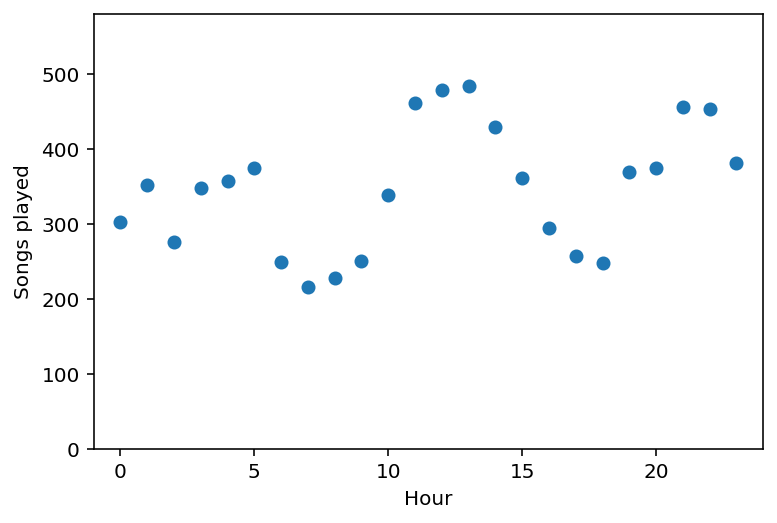

In [23]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [26]:
# by MV:Creé esta visualización para mostrar todos los userIds que están vacíos
user_ids = user_log.groupby(user_log.userId).count().orderBy(user_log.userId)
user_ids.show()

+------+-----+
|userId|count|
+------+-----+
|      |  336|
|    10|    2|
|   100|    8|
|  1000|    1|
|  1003|    3|
|  1005|    1|
|  1006|    3|
|  1017|   12|
|  1019|   30|
|  1020|    5|
|  1022|    2|
|  1025|    5|
|  1030|    1|
|  1035|  103|
|  1037|   14|
|   104|    6|
|  1040|    2|
|  1042|    5|
|  1043|    3|
|  1046|   30|
+------+-----+
only showing top 20 rows



In [32]:
# by MV: Creé esta visualización para mostrar todos los sessionIds que están vacíos
session_ids = user_log.groupby(user_log.sessionId).count().orderBy(user_log.sessionId)
session_ids.show()

+---------+-----+
|sessionId|count|
+---------+-----+
|        9|    1|
|       10|    3|
|       27|   71|
|       31|    1|
|       37|    1|
|       39|    4|
|       58|    1|
|       59|    1|
|       60|    3|
|      106|    5|
|      107|   15|
|      116|    3|
|      119|    3|
|      129|    1|
|      136|    1|
|      137|    1|
|      149|    3|
|      157|    1|
|      158|    1|
|      159|    1|
+---------+-----+
only showing top 20 rows



In [27]:
# Acá eliminamos cualquier registro de log que tenga userId nulo ó sessionId nulo 
# Aunque no hay sessionIds nulos, como se vio más arriba está bueno como demostración
# how = "any" significa que se borra cualquier fila que tenga uno de los dos valores listados en el subset, vacíos
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [31]:
# Se ve que no decrece el número de registros, es decir que no son nulos sino empty strings
print(user_log.count())
print(user_log_valid.count())

10000
10000


In [33]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [34]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [35]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [36]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   8|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [37]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [38]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [39]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [40]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='19', downgraded=0)

In [41]:
from pyspark.sql import Window

In [52]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
print(type(windowval))

<class 'pyspark.sql.window.WindowSpec'>


In [53]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [54]:
#Para entender lo que pasa pensá que esto funciona así: 
#	1) Armo la ventana de valores, en este caso una ventana por cada userId, ordenada desde más reciente a más antigua. 
#	2) Ahora me paro en la última fila primero y sumo todos los valores downgraded desde donde estoy hacia a atrás. Pero atrá no hay nada porque el último timestamp es la primera fila
#	3) En la penúltima fila sumo la anterior y ésta
#	4) Seguir así hasta el final (el registro más viejo para ese userId)
#	5) Por eso me da cero en las últimas y uno desde que hizo el downgrade hacia atrás.
#

user_log_valid.select(["userId", "firstname", "ts", "page", "level", "downgraded", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', downgraded=0, phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', downgraded=0, phase=

# Celdas adicionales
En las siguientes celdas hago cálculos para responder las preguntas del Quiz que está en la lección 19

In [9]:
# Pregunta: Qué página no visitó el usuario con userID vacío: About, Home, Login ó NextSong?
# Paso 1: Listo todas las páginas que existen (ya se había hecho arriba, pero lo vuelvo a hacer acá)
user_log.select("page").dropDuplicates().sort("page").show()

# Paso 2: Ver todas las páginas que visitó el usuario de userID=''
user_log.select("page").filter(user_log.userId == '').dropDuplicates().sort("page").show()

# Respuesta: NextSong

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+

+-----+
| page|
+-----+
|About|
| Help|
| Home|
|Login|
+-----+



In [14]:
# Pregunta: Cuántas usuarias mujeres hay?

user_log.filter(user_log.gender == 'F').select(user_log.userId).dropDuplicates().count()

# Respuesta: 3820

462

In [25]:
# Pregunta: Cuántas canciones se reprodujeron del artista más escuchado? 
songs_played = user_log.groupBy(user_log.artist).count().sort('count', ascending = 0) 
songs_played.show()

# Respuesta: 83 de Coldplay

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|Barry Tuckwell/Ac...|   28|
|          Lily Allen|   28|
|               Train|   28|
|           Metallica|   27|
|           Daft Punk|   27|
|          Nickelback|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



In [30]:
# Pregunta: Cuántas canciones escuchan los usuarios en promedio entre visitas a la Home Page? 

# Paso 1: Contar visitas a la home: 1126
user_log.filter(user_log.page == 'Home').count()
# Paso 2: Contar Canciones escuchadas: 8347
user_log.filter(user_log.page == 'NextSong').count()

print(8347/1126)

# Resultado: 7.41

7.412966252220249
